<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implémentez un modèle de scoring - P7</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Études des modèles |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist - OpenClassrooms</h4>
</div>

In [9]:
## General
import timeit
import re
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns

## Scikit Learn library
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, StratifiedKFold, KFold, 
                                     HalvingGridSearchCV, cross_validate, GridSearchCV)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
## LightGBM
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (precision_score, roc_auc_score, recall_score, 
                             f1_score, fbeta_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
                             )
from sklearn.feature_selection import SelectKBest, f_classif

## imbalanced-learn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier,RUSBoostClassifier


## SHapley Additive exPlanations.
#import shap
import pickle
## Lightweight pipelining in Python
import joblib


%matplotlib inline

#!pip3 install imblearn


In [2]:
#from sklearn.pipeline import make_pipeline, Pipeline

# I/ Analyse succinte du fichier 

In [18]:
data=pd.read_csv("df_current_clients.csv")
data.shape

(307507, 608)

In [20]:
data["SK_ID_CURR"]

0         100002.0
1         100003.0
2         100004.0
3         100006.0
4         100007.0
            ...   
307502    456251.0
307503    456252.0
307504    456253.0
307505    456254.0
307506    456255.0
Name: SK_ID_CURR, Length: 307507, dtype: float64

In [21]:
data.isnull().mean().sort_values()

SK_ID_CURR                                                  0.0
PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN                  0.0
PREV_NAME_CASH_LOAN_PURPOSE_Gasificationwatersupply_MEAN    0.0
PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN                      0.0
PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN                    0.0
                                                           ... 
ORGANIZATION_TYPE_Realtor                                   0.0
ORGANIZATION_TYPE_Religion                                  0.0
ORGANIZATION_TYPE_Restaurant                                0.0
ORGANIZATION_TYPE_Military                                  0.0
INSTAL_COUNT                                                0.0
Length: 608, dtype: float64

# II/ Utilisation direct des données

In [23]:
not_feats_columns  = ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']
[i for i in data.columns if i in not_feats_columns]  

['SK_ID_CURR', 'TARGET']

In [24]:
feats= [col for col in data.columns if col not in ['SK_ID_CURR', 'TARGET']]

In [25]:
X = data[feats]
Y = data.loc[:,"TARGET"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

In [12]:
print("X_train: {} et y_train: {}".format(X_train.shape, y_train.shape))
print("---------------------")
print("X_test: {} et y_test: {}".format(X_test.shape, y_test.shape))

X_train: (246005, 606) et y_train: (246005,)
---------------------
X_test: (61502, 606) et y_test: (61502,)


In [22]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = ["roc_auc", "recall", "f1"]


classifiers = {
    "Random Forest" : RandomForestClassifier(),
    "LightGBM" : LGBMClassifier(),
    "Gradient Boosting" : GradientBoostingClassifier(),
    "LogisticRegression" : LogisticRegression(random_state=4),
    "xgboost" : xgb.XGBClassifier()
}

In [17]:
# List of metrics results for each models 
LIST_MODEL, LIST_RECALL, LIST_ROC_AUC, LIST_F1, LIST_DURATION  = ([] for i in range(5))

for key, clf in classifiers.items():
    
    start_time_model = timeit.default_timer()
    
    scores = cross_validate(clf, X_train, y_train, 
                            cv=stratified_kfold, scoring=scoring)
    
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    
    # Adding results into LIST
    LIST_MODEL.append(key)
    LIST_RECALL.append(round(scores.get("test_recall").mean(), 3))
    LIST_ROC_AUC.append(round(scores.get("test_roc_auc").mean(), 3))
    LIST_F1.append(round(scores.get("test_f1").mean(), 3))
    LIST_DURATION.append(end_time_model)

/home/bdiallo/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/bdiallo/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [21]:
list_result={"ROC_AUC":LIST_ROC_AUC, "F1": LIST_F1, "recall": LIST_RECALL}
list_result

{'ROC_AUC': [0.71, 0.777, 0.769, 0.572, 0.767],
 'F1': [0.002, 0.068, 0.04, 0.001, 0.105],
 'recall': [0.001, 0.036, 0.021, 0.0, 0.06]}

In [40]:
df_models_result= pd.DataFrame([LIST_ROC_AUC,LIST_F1,
                               LIST_RECALL], index=list_result.keys(), columns = LIST_MODEL)
df_models_result


,Random Forest,LightGBM,Gradient Boosting,LogisticRegression,xgboost
ROC_AUC,0.710,0.777,0.769,0.572,0.767
F1,0.002,0.068,0.040,0.001,0.105
recall,0.001,0.036,0.021,0.000,0.060


In [30]:
df_models_result=pd.read_csv("comp_model.csv", sep="\t", index_col=None)

In [44]:
#df_models_result.index=["ROC_AUC","F1", "recall"]
#df_models_result

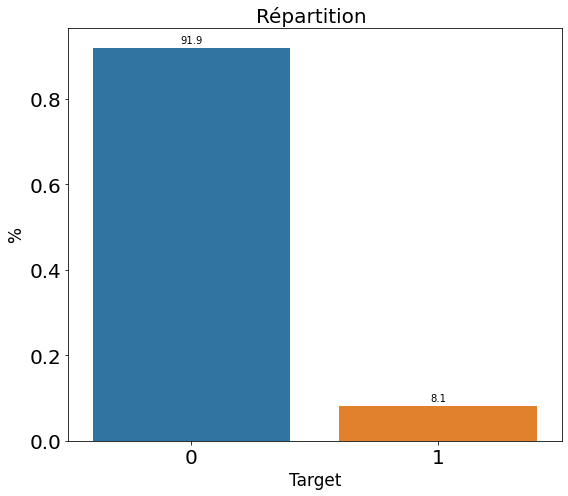

In [46]:
fig = plt.subplots(figsize=(8, 7))
SIZE=20
plot=sns.barplot(
    x=y_train.value_counts().index,
    y=y_train.value_counts(normalize=True),
)

for p in plot.patches:
    plot.annotate(format(p.get_height()*100, ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Répartition ", size=20)
plt.xlabel("Target", size=17)
plt.ylabel("%", size=17)

plt.rc('axes', labelsize=SIZE) 
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE)
plt.tight_layout()
plt.savefig("fig/repartition_target.png")

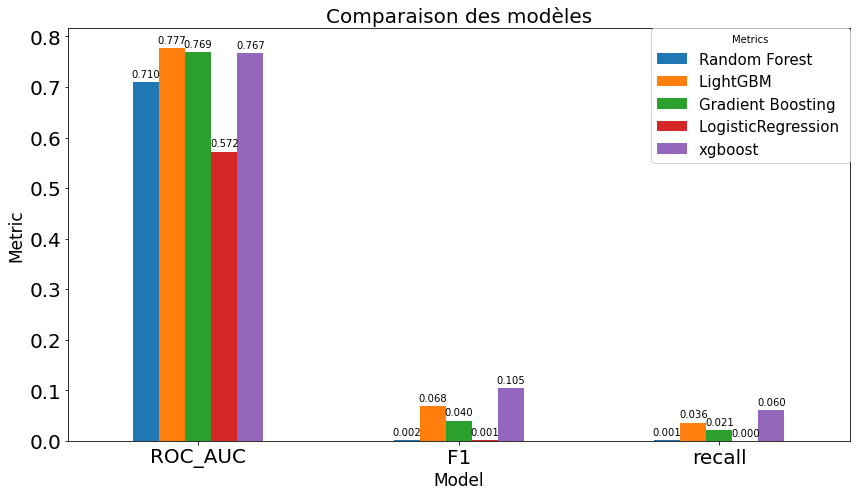

In [41]:
SIZE=18
plot= df_models_result.plot.bar(rot=0, figsize=[12,7])
plt.title("Comparaison des modèles", size=20)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0, title="Metrics", prop={'size':15})
plt.tight_layout()
plt.xlabel("Model", size=17)
plt.ylabel("Metric", size=17)

plt.rc('axes', labelsize=SIZE) 
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE)
plt.tight_layout()
plt.savefig("fig/comparaison_model.png")

Dans ce résultat le modèle LightGBM est celui qui présente le meilleur résultat de ROC_AUC. Dans le kernel précédemment étudié  "<citation>" le modèle LightGBM a été optimisé et les resultats du ROC_AUC ont augmenté. Il a obtenue une valeur de de **0.79** en moyenne. avec les paramètres suivante :<br/>
    <div class="alert alert-block alert-success">
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1
    </div>
    
 En analysant les différents scoring on note que le modèle **xgboost** est celui qui a une meilleure réprésentation du recall et du F1. <br/>Cependant, on note une surreprésentation de la classe majoritaire donc pour résoudre ce déséquilibre, je choisi dans la suite de réanchantilloner en utilisant "**SMOTE**"

# III/ Réechantillonage avec SMOTE

SMOTE est une méthode de sur-échantillonnage. </br>
Elle fonctionne en créant des échantillons synthétiques à partir de la classe minoritaire au lieu de créer de simples copies. 

In [17]:
oversample = SMOTE(random_state=42)
X_train_bal, y_train_bal = oversample.fit_resample(X_train, y_train)

In [18]:
print("Train size before balancing : {}".format(X_train.shape))
print("Train size after balancing : {}".format(X_train_bal.shape))

Train size before balancing : (246005, 606)
Train size after balancing : (452290, 606)


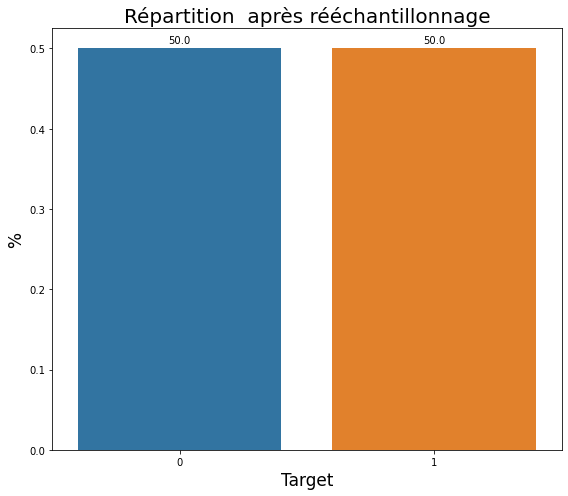

In [19]:
fig = plt.subplots(figsize=(8, 7))
SIZE=20
plot= sns.barplot(
    x=y_train_bal.value_counts().index,
    y=y_train_bal.value_counts(normalize=True),
)
for p in plot.patches:
    plot.annotate(format(p.get_height()*100, ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Répartition  après rééchantillonnage", size=20)
plt.xlabel("Target", size=17)
plt.ylabel("%", size=17)

plt.rc('axes', labelsize=SIZE) 
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE)
plt.tight_layout()
#plt.savefig("fig/repartition_target_SMOTE.png")

In [ ]:
# List of metrics results for each models 
LIST_MODEL_2, LIST_RECALL_2, LIST_ROC_AUC_2, LIST_F1_2, LIST_DURATION_2  = ([] for i in range(5))

for key, clf in classifiers.items():
    
    start_time_model = timeit.default_timer()
    
    scores = cross_validate(clf, X_train_bal, y_train_bal, 
                            cv=stratified_kfold, scoring=scoring)
    
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    
    # Adding results into LIST
    LIST_MODEL_2.append(key)
    LIST_RECALL_2.append(round(scores.get("test_recall").mean(), 3))
    LIST_ROC_AUC_2.append(round(scores.get("test_roc_auc").mean(), 3))
    LIST_F1_2.append(round(scores.get("test_f1").mean(), 3))
    LIST_DURATION_2.append(end_time_model)

In [61]:
list_result_2={"ROC_AUC":LIST_ROC_AUC_2, "F1": LIST_F1_2, "recall": LIST_RECALL_2}
df_models_result_2= pd.DataFrame([LIST_ROC_AUC_2,LIST_F1_2,
                               LIST_RECALL_2], index=list_result_2.keys(), columns = LIST_MODEL_2)
df_models_result_2

,Random Forest,LightGBM,LogisticRegression,xgboost
ROC_AUC,0.972,0.967,0.605,0.966
F1,0.918,0.920,0.400,0.921
recall,0.849,0.865,0.359,0.862


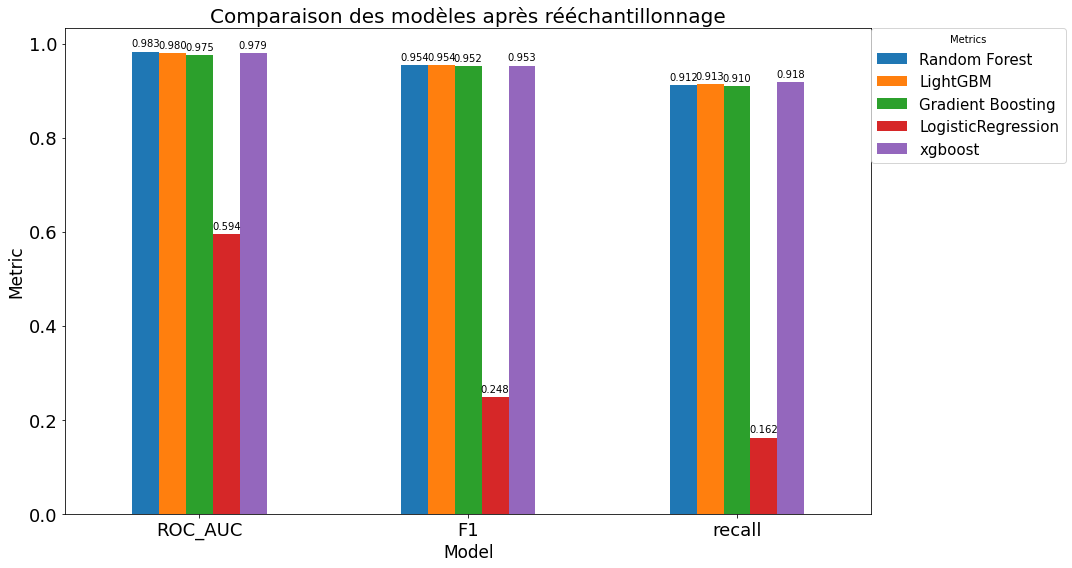

In [43]:
SIZE=18
plot= df_models_result_2.plot.bar(rot=0, figsize=[15,8])
plt.title("Comparaison des modèles après rééchantillonnage", size=20)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0, title="Metrics", prop={'size':15})
plt.tight_layout()
plt.xlabel("Model", size=17)
plt.ylabel("Metric", size=17)

plt.rc('axes', labelsize=SIZE) 
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE)
plt.tight_layout()
plt.savefig("fig/comparaison_model_smote.png")

 <div class="alert alert-block alert-success">
    La méthode de réechantillonnage avant l'entraînement créer un overfiting. Aussi pour ces données déséquilibrés ont peut utiliser d'autres méthodes  comme celui de: <h4>modèles d’ensembles qui sont entraînés à chaque étape de l’algorithme sur un échantillon rééquilibré automatiquement entre les différentes classes et donc de se passer de méthodes de rééchantillonnage avant l’entraînement</h4>
 </div>

# IV/ Modèles avec échantillonneurs d'équilibrage intérieurs

In [53]:
#scale_pos_weight est le rapport du nombre de classes négatives à la classe positive on prend à 11
classifiers_imb = {
    "RandomForest_imb" : BalancedRandomForestClassifier(),
    "LightGBM_imb" : LGBMClassifier(scale_pos_weight=11),
    "Boosting_imb" : RUSBoostClassifier(),
    "Bagging_imb" : BalancedBaggingClassifier(),
    "xgboost_imb" : xgb.XGBClassifier(scale_pos_weight=11)
}

In [54]:
# List of metrics results for each models 
LIST_MODEL_3, LIST_RECALL_3, LIST_ROC_AUC_3, LIST_F1_3, LIST_DURATION_3  = ([] for i in range(5))

for key, clf in classifiers_imb.items():
    
    start_time_model = timeit.default_timer()
    
    scores_imb = cross_validate(clf, X_train, y_train,
                            cv=stratified_kfold, scoring=scoring)
    
    end_time_model_imb =  round(timeit.default_timer() - start_time_model, 3)
    
    # Adding results into LIST
    LIST_MODEL_3.append(key)
    LIST_RECALL_3.append(round(scores_imb.get("test_recall").mean(), 3))
    LIST_ROC_AUC_3.append(round(scores_imb.get("test_roc_auc").mean(), 3))
    LIST_F1_3.append(round(scores_imb.get("test_f1").mean(), 3))
    LIST_DURATION_3.append(end_time_model_imb)

In [55]:
list_result_3={"ROC_AUC":LIST_ROC_AUC_3, "F1": LIST_F1_3, "recall": LIST_RECALL_3}
df_models_result_3= pd.DataFrame([LIST_ROC_AUC_3,LIST_F1_3,
                               LIST_RECALL_3], index=list_result_3.keys(), columns = LIST_MODEL_3)
df_models_result_3

,RandomForest_imb,LightGBM_imb,Boosting_imb,Bagging_imb,xgboost_imb
ROC_AUC,0.743,0.778,0.755,0.703,0.757
F1,0.260,0.291,0.267,0.253,0.295
recall,0.667,0.671,0.679,0.428,0.559


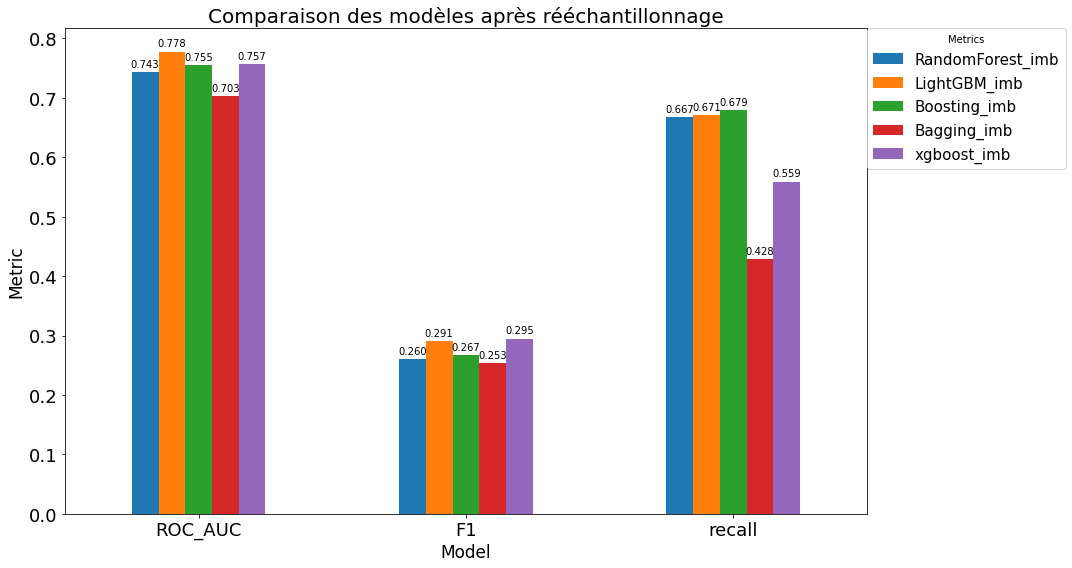

In [56]:
SIZE=18
plot= df_models_result_3.plot.bar(rot=0, figsize=[15,8])
plt.title("Comparaison des modèles après rééchantillonnage", size=20)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0, title="Metrics", prop={'size':15})
plt.tight_layout()
plt.xlabel("Model", size=17)
plt.ylabel("Metric", size=17)

plt.rc('axes', labelsize=SIZE) 
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE)
plt.tight_layout()
plt.savefig("comparaison_model_imb_11.png")

# V/ Recherche des meilleurs hyperparamètres avec  LightGBM et Boosting

## a) LightGBM

In [57]:
parameters_1={'max_depth': [7, 8, 9],
            'num_leaves': [32, 34],
            'learning_rate': [0.01,0.02,0.03],
            'colsample_bytree':[0.8,0.9, 1]}


LightGBMgrid = GridSearchCV(LGBMClassifier(random_state=4,scale_pos_weight=11),
                        param_grid = parameters_2,verbose=-1,cv=stratified_kfold,
                        scoring='roc_auc')

In [59]:
LightGBMgrid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LGBMClassifier(random_state=4, scale_pos_weight=11),
             param_grid={'colsample_bytree': [0.8, 0.9, 1],
                         'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [7, 8, 9], 'num_leaves': [32, 34]},
             scoring='roc_auc', verbose=-1)

In [60]:
filename = 'LightGBM_imb.pkl'
with open(filename, 'wb') as file:
    pickle.dump(LightGBMgrid,file)

In [61]:
LightGBMgrid.best_score_,LightGBMgrid.best_params_

(0.7673576065045916,
 {'colsample_bytree': 0.9,
  'learning_rate': 0.03,
  'max_depth': 9,
  'num_leaves': 34})

In [63]:
roc_auc_score(LightGBMgrid.predict(X_test), y_test)

0.5719374734769672

In [67]:
joblib.dump(LightGBMgrid, 'LightGBMgrid_imb.joblib')

['LightGBMgrid_imb.joblib']

## b) Boosting

In [70]:
parameters_2 = {'n_estimators' : [50,100], 'learning_rate': [0.01,0.02,0.03]}
              
Boostingrid = GridSearchCV(RUSBoostClassifier(random_state=4),
                        param_grid = parameters_2, verbose=-1, cv=stratified_kfold,
                        scoring='roc_auc')

Boostingrid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RUSBoostClassifier(random_state=4),
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'n_estimators': [50, 100]},
             scoring='roc_auc', verbose=-1)

In [72]:
import pickle

filename = 'Boosting_imb.pkl'
with open(filename, 'wb') as file:
    pickle.dump(Boostingrid,file)

joblib.dump(Boostingrid, 'Boostingrid_imb.joblib')

['Boostingrid_imb.joblib']

## c) Récaputilatif des résultats

In [23]:
##mlflow
#from mlflow.models.signature import infer_signature
#import mlflow.sklearn
#signature_2 = infer_signature(X_train_set, y_train_set)
#mlflow.sklearn.save_model(Randomgrid_model, 'mlflow_model_random', signature=signature_2)


#mlflow models serve -m mlflow_model_random/ ##pour le deploiement faire dans le terminale
## créer  http://127.0.0.1:5000 (35665)
#curl http://127.0.0.1:5000/invocations -H 'Content-Type: application/json' -d '{"data": [donnnee]}'

In [ ]:
models_score_imb = pd.DataFrame({})    
models_score_imb = models_score_imb.append(pd.DataFrame(
    {'Models' : ['LightGBM_imb','Boosting_imb'],
     'Training_set' : [LightGBMgrid.best_score_, Boostingrid.best_score_],
     'Validation_set_roc_auc' : [roc_auc_score(LightGBMgrid.predict(X_test), y_test),
                                 roc_auc_score(Boostingrid.predict(X_test), y_test)]}),
                                   ignore_index=True)
models_score_imb

In [79]:
models_score_imb.to_csv('models_score_imbalance.csv')

In [30]:
pd.read_csv("models_score_imbalance.csv")

,Unnamed: 0,Models,Training_set,Validation_set_roc_auc
0,0,LightGBM_imb,0.767358,0.571937
1,1,Boosting_imb,0.717664,0.553067


## d) Recharge des modèles

In [3]:
#recharge des modèles 
filename_RF = 'LightGBM_imb.pkl'
filename_xgb= 'Boosting_imb.pkl'
lightgrid = pickle.load(open(filename_RF, 'rb'))
boogrid = pickle.load(open(filename_xgb, 'rb'))

In [27]:
(TN, FP, FN, TP)=confusion_matrix(lightgrid.predict(X_test), y_test, labels=[0, 1]).ravel()
#fonction_cout_metier=10*FN+FP

In [37]:
(TN, TP, FP, FN)

(41974, 3260, 1705, 14563)

In [38]:
cm = confusion_matrix(y_test, lightgrid.predict(X_test), labels=lightgrid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lightgrid.classes_)

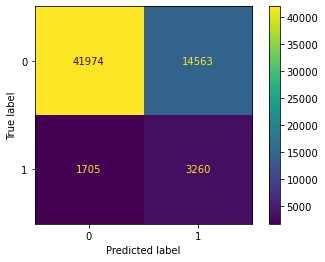

In [39]:
disp.plot()

# VII/ Définition du score et de la fonction coût métier

La fonction coût métier est une fonction qui prend en compte les exigences métiers. Elle permet aux
gestionnaires de savoir si avec le modèle choisi il n’y aura pas de perte d’argent. En effet, si on
accorde un prêt à un client non solvable cela va coûter beaucoup plus cher à la société que de ne pas
accorder de prêt à un client solvable.
Donc pour favoriser le faite qu’il y ai moins de perte d’argent, il est important de fixer un seuil très
élevé à partir du quel on peut considérer que ce qui client est fiable. J’ai donc choisi qun seuil (
c’est à dire la valeur de probabilité à partir duquel le client est considéré comme un bon client) à
0.7. Ce seuil correspond à un score de 14/20 

## a) Fonction pour le calcul du score

In [7]:
def predict_target(ID_client,modelname):

    model = modelname
    filename = "df_current_clients.csv"
    data = pd.read_csv(filename)    

    X = data[data['SK_ID_CURR'] == int(ID_client)]
    X.drop(['SK_ID_CURR','TARGET'],axis=1,inplace=True)

    prediction = int(model.predict(X)[0])
    proba = model.predict_proba(X)[0][prediction]

    return prediction, proba

def get_client_score(ID_client,prediction,proba):

    T = pd.DataFrame(columns=["A","B","Note"])

    j = 0
    for i in range(1,21):
        T.loc[i-1,"A"] = j
        T.loc[i-1,"B"] = j + 0.05
        T.loc[i-1,"Note"] = i
        j = j + 0.05

    if prediction == 1:
        proba = 1 - proba

    prob_data = pd.DataFrame(columns=["Proba","Note","arrow_idx"])

    X_val = T[(proba >=T["A"]) & (proba <T["B"])]

    prob_data = prob_data.append(pd.DataFrame(
            {'Proba' : [proba],'Note' : [X_val["Note"].values[0]],
             'arrow_idx' : [X_val["Note"].values[0] * 50]}),
            ignore_index=True)

    prob_data['SK_ID_CURR'] = int(ID_client)
    prob_data['TARGET'] = prediction

    return prob_data

## b) Exemples de fonctionnement 

In [53]:
prediction, proba = predict_target(100002,lightgrid)

In [54]:
proba_data=get_client_score(100002,prediction,proba)
proba_data["Note"]

0    5
Name: Note, dtype: object

<h5>En conclusion ce client n'aura pas de crédit</h5>

In [56]:
prediction, proba = predict_target(100006,lightgrid)


In [59]:
proba_data=get_client_score(100006,prediction,proba)
proba_data["Note"]

0    14
Name: Note, dtype: object

<h5>Ce client lui pourra beneficier d'un credit </h5>